In [2]:
import os
from os import path as op
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from mne import EvokedArray
from mne.datasets import fetch_fsaverage
from scipy import stats
from scipy.stats import ttest_1samp, ttest_rel
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from vr2f import helpers
from vr2f.staticinfo import COLORS, CONFIG, PATHS, TIMINGS


In [8]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=None,
    scoring="roc_auc_ovr",
    picks_str=None,
    gen_str=None,
):
    """
    Load decoding results per viewing condition for a set of subjects and conditions.

    This function loads scores, times, and patterns associated with decoding results for
    each specified viewing condition. Data for each condition and subject is stored in
    a nested dictionary.

    Parameters
    ----------
    sub_list_str : list of str
        List of subject identifiers as strings, e.g., ['sub01', 'sub02'].
    conditions : list of str
        List of conditions to contrast (i.e., the decoding target classes), e.g., ['angry', 'neutral'].
    vc_list : list of str, optional
        List of viewing conditions to load, e.g. ["mono", "stereo"]. If empty, defaults to [""].
        "" (empty string) loads data pooled across viewing conditions.
    scoring : str, optional
        Metric used to score decoding results, by default "roc_auc_ovr".
    picks_str : str, optional
        String identifier for channel or sensor selections used during decoding. Defaults to None.
    gen_str : str, optional
        String identifier for generalization parameters (i.e., temporal generalization). Defaults to None.

    Returns
    -------
    dict
        A dictionary where each key is a viewing condition from `vc_list`.
        Each viewing condition maps to a dictionary with the following keys:

        - 'scores' : ndarray
            Array of decoding scores for each subject.
        - 'times' : ndarray
            Array of time points for decoding scores.
        - 'patterns' : ndarray
            Array of decoding patterns for each subject.

    Notes
    -----
    - The function assumes a specific directory structure defined by the `PATHS` object.
    - Decoding scores, times, and patterns are loaded from `.npy` files.
    - Ensures that 'times' arrays are consistent across subjects for each viewing condition.

    """
    if vc_list is None:
        vc_list = [""]
    data_dict = {}
    picks_str_folder = picks_str if picks_str is not None else ""
    gen_folder = gen_str if gen_str is not None else ""

    paths = PATHS()

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[], patterns=[])
        for sub_id in sub_list_str:
            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                vc,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "scores",
            )
            fname = Path(fpath, f"{sub_id}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[vc]["scores"].append(scores_)

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")
            elif not np.all(data_dict[vc]["times"] == np.load(str(fname)[:-4] + "__times" + ".npy")):
                raise ValueError("Times are different between subjects.")

            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                vc,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "patterns",
            )
            fname = op.join(fpath, f"{sub_id}-patterns_per_sub.npy")
            patterns_ = np.load(fname)
            data_dict[vc]["patterns"].append(patterns_)

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])
        data_dict[vc]["patterns"] = np.array(data_dict[vc]["patterns"])

    return data_dict


def load_patterns(
    sub_list_str,
    contrast_str,
    viewcond="",
    scoring="accuracy",
    reg="",
    labels_shuffled=False,
):
    """
    Load the patterns from sensor space decoding.

    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from.
    contrast_str : str
        Decoded contrast.
    viewcond : str
        Viewing condition. 'mono', 'stereo', or ''(default) for data pooled across both viewing conditions.
    scoring: str
        Scoring metric used during decoding. "roc_auc", accuracy" (default), or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to an empty string
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d

    """
    paths = PATHS()

    reg_str = "shrinkage" + str(reg) if isinstance(reg, float) else reg
    shuf_labs = "labels_shuffled" if labels_shuffled else ""

    patterns_list = []
    times = []

    for sub_id in sub_list_str:
        fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, viewcond, contrast_str, scoring, "patterns")
        fname = op.join(fpath, f"{sub_id}-patterns_per_sub.npy")
        patterns_ = np.load(fname)
        patterns_list.append(patterns_)
        if len(times) == 0:
            times = np.load(str(fname)[:-4] + "__times" + ".npy")
        else:
            assert np.all(
                times == np.load(str(fname)[:-4] + "__times" + ".npy")
            ), "Times are different between subjects."

    patterns = np.concatenate(patterns_list)
    return patterns, times


def get_info(return_inst=False):
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        "cleaneddata",
        "VR2FEM_S01-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    if return_inst:
        return epos.info, epos
    else:
        return epos.info


def get_epos(sub_id):
    """Load the epochs for a given subject."""
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        "cleaneddata",
        f"{sub_id}-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    epos = epos.set_eeg_reference("average", projection=True)
    return epos


def l2norm(vec):
    """Compute the L2 norm of a vector."""
    out = np.sqrt(np.sum(vec**2))
    return out


def run_cbp_test(data, tail=0):
    """
    Perform a cluster-based permutation test on 1-sample data.

    This function performs a cluster-based permutation test on the provided data
    using a specified tail (one-sided or two-sided). It returns the observed test
    statistics, clusters, and p-values for each cluster.

    Parameters
    ----------
    data : array-like, shape (n_samples, n_features)
        The data on which to perform the cluster-based permutation test. Each row
        represents a sample, and each column represents a time point or feature.
    tail : int, optional
        Specifies the type of test: 1 for a right-tailed test, -1 for a left-tailed test,
        and 0 for a two-tailed test (default).

    Returns
    -------
    t_obs : ndarray
        Observed t-values for each time point or feature.
    clusters : list of ndarray
        List of clusters, where each cluster is represented as an array of indices.
    cluster_p_values : ndarray
        P-values for each cluster, representing the probability of observing a cluster
        as extreme under the null hypothesis.

    Notes
    -----
    - The function performs 10,000 permutations and sets an initial cluster-forming
      threshold with a significance level of 0.05.
    - The `mne.stats.permutation_cluster_1samp_test` function is used for the permutation
      test. It is configured to run with 5 jobs in parallel and a random seed of 42
      for reproducibility.

    """
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    connectivity = None

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=5, # config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    t_obs, clusters, cluster_p_values, _ = cluster_stats
    return t_obs, clusters, cluster_p_values


def plot_score_per_factor(
    factor,
    data,
    scoring="roc_auc",
    sign_clusters=None,
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=10000,
):
    """
    Plot decoding scores over time, grouped by a specified factor.

    Parameters
    ----------
    factor : str
        The column in `data` used to group and color the plot lines.
    data : pandas.DataFrame
        DataFrame containing the decoding scores, with columns including 'time', 'score',
        and `factor`.
    scoring : str, optional
        Metric for decoding performance, by default "roc_auc". Only used for labelling the
        y-axis. If set to "roc_auc", auto-formatted to "ROC AUC".
    sign_clusters : list or dict, optional
        Time intervals where scores are significantly different, formatted as:
        - List of tuples, each defining a start and end time for a single cluster
        (e.g., [(start1, end1), (start2, end2)]), or
        - Dictionary with keys as factor levels and values as lists of tuples
        (e.g., {'factor1': [(start1, end1)], 'factor2': [(start2, end2)]}).
    p_lvl : float, optional
        Significance level, by default 0.05.
    chancelvl : float, optional
        Chance level line for reference on the y-axis, by default 0.5.
    ylims : tuple of float, optional
        Limits for the y-axis as (min, max). If None, the current y-axis limits are used.
    xlims : tuple of float, optional
        Limits for the x-axis as (min, max). If None, the current x-axis limits are used.
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on. If None, uses the current axis.
    n_boot : int, optional
        Number of bootstrap samples for computing confidence intervals, by default 10000.

    Returns
    -------
    None
        The function modifies the given `ax` object with the plot, labels, and annotations.

    Notes
    -----
    - The function uses seaborn's `lineplot` to plot time-resolved decoding scores, grouped by `factor`.
    - Significance clusters are visualized as horizontal lines, with color corresponding to
      factor levels if `sign_clusters` is a dictionary.
    - If `sign_clusters` is not empty, a significance level label (e.g., "$p$ < .05") is added to
      the plot.

    """
    if sign_clusters is None:
        sign_clusters = []
    colors = COLORS()

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=colors.COLDICT,
        ax=ax,
        linewidth=1.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    scoring_str = "ROC AUC" if scoring == "roc_auc" else scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s="chance", ha="right")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = colors.COLDICT[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.01 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i == 0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    handles, labels = ax.get_legend_handles_labels()


def prep_and_plot_from_data(data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32), scoring="roc_auc"):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [times[clusters[idx[0]]][[0, -1]] * 1000 for idx in idx_sign_clusters]
        print(f"Found {len(sign_cluster_times[vc])} significant clusters for viewing condition '{vc}'.")
        for i in range(len(sign_cluster_times[vc])):
            print(f"Significant cluster: {sign_cluster_times[vc][i][0]:.3f} - {sign_cluster_times[vc][i][1]:.3f}")

    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(data_dict[subsets[1]]["scores"])
        t_values, clusters, p_values = run_cbp_test(data, tail=0)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg("Found significant difference between conditions! Do you see that?")

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring=scoring,
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.3, 1.0),
        n_boot=10000,
        ax=ax,
    )


def get_max_decod_score_and_time(data_dict):
  peak_mean = data_dict["scores"].max(axis=1).mean()
  peak_sd = data_dict["scores"].max(axis=1).std()
  peak_cil = peak_mean - 1.96 * peak_sd / np.sqrt(len(data_dict["scores"]))
  peak_ciu = peak_mean + 1.96 * peak_sd / np.sqrt(len(data_dict["scores"]))
  times = data_dict_allemos["all"]["times"]
  tidx = int(np.median(data_dict["scores"].argmax(axis=1)))
  peak_time = times[tidx] * 1000
  peak_time_sd = np.std(times[data_dict["scores"].argmax(axis=1)]) * 1000
  peak_time_cil = peak_time - 1.96 * peak_time_sd / np.sqrt(len(data_dict["scores"]))
  peak_time_ciu = peak_time + 1.96 * peak_time_sd / np.sqrt(len(data_dict["scores"]))
  print(f"Peak mean: M = {peak_mean:.2f}, SD = {peak_sd:.2f}, 95% CI [{peak_cil:.2f}, {peak_ciu:.2f}]")
  print(f"Peak time: M = {peak_time:.2f}, SD = {peak_time_sd:.2f}), 95% CI [{peak_time_cil:.2f}, {peak_time_ciu:.2f}]")
  return peak_mean, peak_sd, peak_cil, peak_ciu, peak_time, peak_time_sd, peak_time_cil, peak_time_ciu


def get_decod_df(data_dict):
  peaks = data_dict["scores"].max(axis=1)
  times = data_dict["times"]
  peak_times = times[data_dict["scores"].argmax(axis=1)] * 1000
  peak_df = pd.DataFrame({"peak": peaks, "peak_time": peak_times})
  return peak_df

def get_binary_results(data_dict_na, contrast_str):
      # print stats:
      print("\nMono:")
      res_mono  = get_max_decod_score_and_time(data_dict_na["mono"])
      print("\nStereo:")
      res_stereo = get_max_decod_score_and_time(data_dict_na["stereo"])

      dd = {("Mono", "Peak", "Mean"): res_mono[0],
            ("Mono", "Peak", "SD"): res_mono[1],
            ("Mono", "Peak", "cil"): res_mono[2],
            ("Mono", "Peak", "ciu"): res_mono[3],
            ("Mono", "Peak", "CI"): f"[{res_mono[2]:.2f}, {res_mono[3]:.2f}]",
            ("Mono", "Time", "Mean"): res_mono[4],
            ("Mono", "Time", "SD"): res_mono[5],
            ("Mono", "Time", "cil"): res_mono[6],
            ("Mono", "Time", "ciu"): res_mono[7],
            ("Mono", "Time", "CI"): f"[{res_mono[6]:.2f}, {res_mono[7]:.2f}]",
            ("Stereo", "Peak", "Mean"): res_stereo[0],
            ("Stereo", "Peak", "SD"): res_stereo[1],
            ("Stereo", "Peak", "cil"): res_stereo[2],
            ("Stereo", "Peak", "ciu"): res_stereo[3],
            ("Stereo", "Peak", "CI"): f"[{res_stereo[2]:.2f}, {res_stereo[3]:.2f}]",
            ("Stereo", "Time", "Mean"): res_stereo[4],
            ("Stereo", "Time", "SD"): res_stereo[5],
            ("Stereo", "Time", "cil"): res_stereo[6],
            ("Stereo", "Time", "ciu"): res_stereo[7],
            ("Stereo", "Time", "CI"): f"[{res_stereo[6]:.2f}, {res_stereo[7]:.2f}]",
            }

      # run paired t-test:
      df_mono = get_decod_df(data_dict_na["mono"])
      df_stereo = get_decod_df(data_dict_na["stereo"])
      ttest_res = stats.ttest_rel(df_mono["peak"], df_stereo["peak"])
      print("\nStats (mono vs stereo):")
      print(f"Peak stats (paired t test): t = {ttest_res.statistic:.2f}, p = {ttest_res.pvalue:.3f}")
      dd[("Stats", "Peak", f"t({ttest_res.df})")] = ttest_res.statistic
      dd[("Stats", "Peak", "p")] = ttest_res.pvalue

      ttest_res_time = stats.ttest_rel(df_mono["peak_time"], df_stereo["peak_time"])
      print(f"Peak time stats: t = {ttest_res_time.statistic:.2f}, p = {ttest_res_time.pvalue:.3f}")
      dd[("Stats", "Time", f"t({ttest_res_time.df})")] = ttest_res_time.statistic
      dd[("Stats", "Time", "p")] = ttest_res_time.pvalue

      del ttest_res, ttest_res_time, res_mono, res_stereo, df_mono, df_stereo

      df = pd.DataFrame(dd, index=[contrast_str])
      return df


def print_table_contrasts(variable="Peak"):
  binary_contrasts = [("angry", "neutral"),
                      ("angry", "happy"),
                      ("angry", "surprised"),
                      ("happy", "neutral"),
                      ("happy", "surprised"),
                      ("surprised", "neutral"),
                      ("id1", "id2", "id3")]

  mydf = pd.DataFrame()
  for c in binary_contrasts:
      print(f"\n\n\nContrast: {' vs '.join(c)}")
      data_dict_na = load_decod_res_per_viewcond(
              sub_list_str=sub_list_str,
              conditions=list(c),
              vc_list=["mono", "stereo"],
              scoring="roc_auc_ovr",
      )
      ddf = get_binary_results(data_dict_na, "  vs  ".join(c))
      mydf = pd.concat([mydf, ddf]) if mydf.size else ddf

  # Peak scores:
  idx = pd.IndexSlice
  peak_df = mydf.loc[:, idx[:, variable, :]]
  # remove useless level of the multiindex:
  peak_df.columns = peak_df.columns.droplevel(1)

  idx = pd.IndexSlice
  pval_cols = idx[:, idx[:,"p"]]
  sdf = peak_df.drop(columns=["cil", "ciu"], level=1) \
            .style \
            .set_table_styles([dict(selector="th", props=[("text-align", "center")])]) \
            .format(lambda x: f"{x:.2f}" if isinstance(x, float) else x) \
            .format("{:.3f}", subset=pval_cols)
  display(sdf)
  print(sdf.to_latex(multicol_align="c", hrules=True, column_format="lcccccccc"))


In [5]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54

# plotting:

p_val_cbp = 0.05

paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")

# load data
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]
# Sort it:
sub_list_str.sort()

## Multiclass decoding "emotion"

A classifier which distinguishes between the four emotional expressions (pooled across the two viewing conditions):

In [6]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")


Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 94.000 - 1000.000


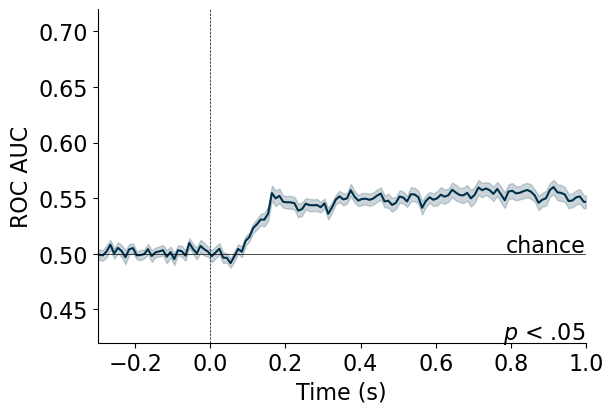

In [9]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(data_dict_allemos,
                        subsets=["all"],
                        ax=ax,
                        chancelvl=0.5,
                        ylims=(0.42, 0.72))



In [5]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list= ["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")

Now per viewing condition:

Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000
Found 1 significant clusters for viewing condition 'mono'.
Significant cluster: 94.000 - 1000.000


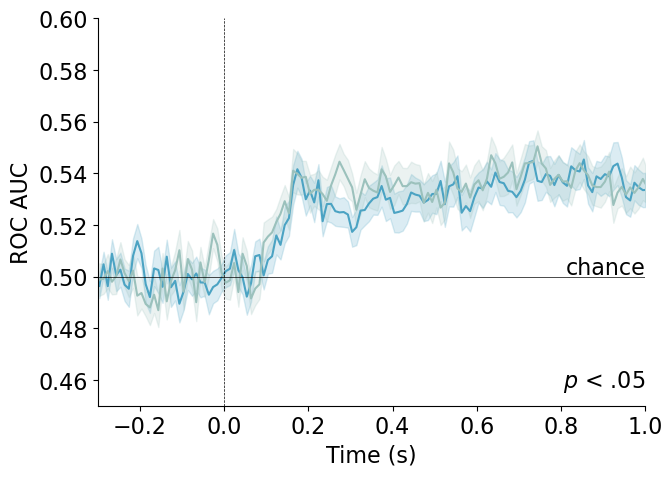

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

prep_and_plot_from_data(
    data_dict=data_dict_allemos,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.60),
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

# leave more space around the plot:


fig.savefig(
    Path(paths.FIGURES, "decod_emo-all_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)



In [8]:
# Overall:
print("All:")
_ = get_max_decod_score_and_time(data_dict_allemos["all"])
# Mono:
print("\nMono:")
_ = get_max_decod_score_and_time(data_dict_allemos["mono"])
print("\nStereo:")
_ = get_max_decod_score_and_time(data_dict_allemos["stereo"])

# run paired t-test:
df_mono = get_decod_df(data_dict_allemos["mono"])
df_stereo = get_decod_df(data_dict_allemos["stereo"])
t_peak_results = stats.ttest_rel(df_mono["peak"], df_stereo["peak"])
t_peak = t_peak_results.statistic
p_peak = t_peak_results.pvalue
df_peak = t_peak_results.df
print("\nStats (mono vs stereo):")
print(f"Peak stats (paired t test): t({df_peak}) = {t_peak:.2f}, p = {p_peak:.3f}")
t_peak_time_results = stats.ttest_rel(df_mono["peak_time"], df_stereo["peak_time"])
print(f"Peak time stats: t({t_peak_time_results.df}) = {t_peak_time_results.statistic:.2f}, p = {t_peak_time_results.pvalue:.3f}")

All:
Peak mean: M = 0.61, SD = 0.03, 95% CI [0.60, 0.62]
Peak time: M = 414.00, SD = 315.81), 95% CI [306.25, 521.75]

Mono:
Peak mean: M = 0.61, SD = 0.02, 95% CI [0.60, 0.62]
Peak time: M = 384.00, SD = 287.71), 95% CI [285.83, 482.17]

Stereo:
Peak mean: M = 0.61, SD = 0.03, 95% CI [0.60, 0.62]
Peak time: M = 524.00, SD = 386.06), 95% CI [392.28, 655.72]

Stats (mono vs stereo):
Peak stats (paired t test): t(32) = -0.49, p = 0.627
Peak time stats: t(32) = -1.04, p = 0.305


Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 114.000 - 1000.000


Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000
Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 144.000 - 954.000
Significant cluster: 974.000 - 1000.000


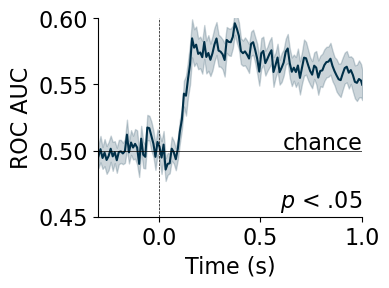

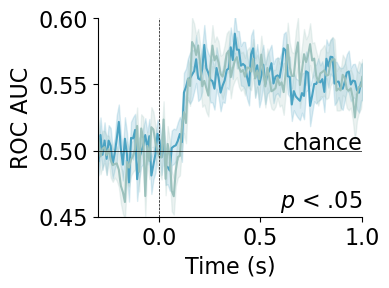

In [9]:
## Contrast: angry-happy

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "happy"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-happy_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-happy_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

## Binary Contrasts
Now we look into decoding binary comparisons of emotions.

### 1. Angry vs neutral

Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000
Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 114.000 - 914.000
Significant cluster: 934.000 - 1000.000


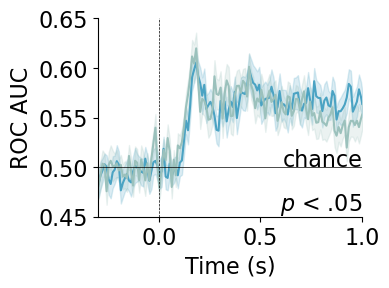

In [10]:
## Contrast: angry-neutral

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "neutral"],
    vc_list=["mono", "stereo"],
    scoring="roc_auc_ovr",
)
if "" in data_dict_na:
    data_dict_na["all"] = data_dict_na.pop("")

if "all" in data_dict_na:
    fig, ax = plt.subplots(1, 1, figsize=(8.0 * cm, 6.0 * cm))
    prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_angry-vs-neutral_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )


fig, ax = plt.subplots(1, 1, figsize=(8.0 * cm, 6.0 * cm))

prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [11]:

# All binary contrasts:

print_table_contrasts("Peak")
print_table_contrasts("Time")





Contrast: angry vs neutral

Mono:
Peak mean: M = 0.74, SD = 0.06, 95% CI [0.72, 0.76]
Peak time: M = 344.00, SD = 230.94), 95% CI [265.20, 422.80]

Stereo:
Peak mean: M = 0.74, SD = 0.05, 95% CI [0.72, 0.76]
Peak time: M = 454.00, SD = 363.03), 95% CI [330.14, 577.86]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.17, p = 0.869
Peak time stats: t = -0.89, p = 0.381



Contrast: angry vs happy

Mono:
Peak mean: M = 0.73, SD = 0.05, 95% CI [0.71, 0.74]
Peak time: M = 334.00, SD = 278.11), 95% CI [239.11, 428.89]

Stereo:
Peak mean: M = 0.72, SD = 0.06, 95% CI [0.70, 0.74]
Peak time: M = 344.00, SD = 307.00), 95% CI [239.25, 448.75]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.42, p = 0.679
Peak time stats: t = -0.59, p = 0.561



Contrast: angry vs surprised

Mono:
Peak mean: M = 0.70, SD = 0.04, 95% CI [0.69, 0.72]
Peak time: M = 184.00, SD = 311.88), 95% CI [77.59, 290.41]

Stereo:
Peak mean: M = 0.70, SD = 0.05, 95% CI [0.68, 0.71]
Peak time: M = 194.00, S

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(32) & p \\
\midrule
angry  vs  neutral & 0.74 & 0.06 & [0.72, 0.76] & 0.74 & 0.05 & [0.72, 0.76] & 0.17 & 0.869 \\
angry  vs  happy & 0.73 & 0.05 & [0.71, 0.74] & 0.72 & 0.06 & [0.70, 0.74] & 0.42 & 0.679 \\
angry  vs  surprised & 0.70 & 0.04 & [0.69, 0.72] & 0.70 & 0.05 & [0.68, 0.71] & 0.65 & 0.523 \\
happy  vs  neutral & 0.72 & 0.04 & [0.70, 0.73] & 0.70 & 0.05 & [0.69, 0.72] & 1.98 & 0.056 \\
happy  vs  surprised & 0.72 & 0.04 & [0.71, 0.74] & 0.71 & 0.05 & [0.69, 0.73] & 1.38 & 0.176 \\
surprised  vs  neutral & 0.72 & 0.05 & [0.70, 0.74] & 0.72 & 0.06 & [0.70, 0.74] & 0.23 & 0.821 \\
id1  vs  id2  vs  id3 & 0.60 & 0.02 & [0.60, 0.61] & 0.61 & 0.03 & [0.60, 0.62] & -1.44 & 0.159 \\
\bottomrule
\end{tabular}
\end{table}




Contrast: angry vs neutral

Mono:
Peak mean: M = 0.74, SD = 0.06, 95% CI [0.

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(32) & p \\
\midrule
angry  vs  neutral & 344.00 & 230.94 & [265.20, 422.80] & 454.00 & 363.03 & [330.14, 577.86] & -0.89 & 0.381 \\
angry  vs  happy & 334.00 & 278.11 & [239.11, 428.89] & 344.00 & 307.00 & [239.25, 448.75] & -0.59 & 0.561 \\
angry  vs  surprised & 184.00 & 311.88 & [77.59, 290.41] & 194.00 & 272.23 & [101.12, 286.88] & -0.74 & 0.462 \\
happy  vs  neutral & 294.00 & 370.40 & [167.62, 420.38] & 574.00 & 402.62 & [436.63, 711.37] & -1.70 & 0.100 \\
happy  vs  surprised & 624.00 & 384.09 & [492.95, 755.05] & 364.00 & 391.24 & [230.51, 497.49] & 1.36 & 0.184 \\
surprised  vs  neutral & 404.00 & 357.74 & [281.94, 526.06] & 544.00 & 376.77 & [415.45, 672.55] & -0.31 & 0.756 \\
id1  vs  id2  vs  id3 & 124.00 & 293.89 & [23.73, 224.27] & 94.00 & 298.97 & [-8.01, 196.01] & 1.01 & 0.320 \\
\botto

### 2. Surprised vs angry

Found 2 significant clusters for viewing condition 'stereo'.
Significant cluster: 154.000 - 294.000
Significant cluster: 714.000 - 904.000


Found 4 significant clusters for viewing condition 'mono'.
Significant cluster: 164.000 - 274.000
Significant cluster: 324.000 - 364.000
Significant cluster: 724.000 - 774.000
Significant cluster: 834.000 - 914.000


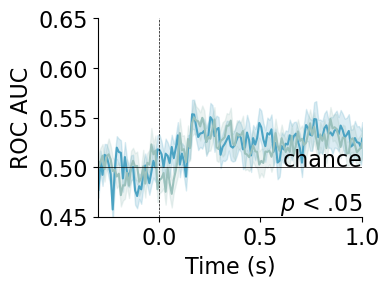

In [12]:
## Contrast: sursprised-angry

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["angry", "surprised"],
    vc_list=["mono", "stereo"],
    scoring="roc_auc_ovr",
)
if "" in data_dict_na:
    data_dict_na["all"] = data_dict_na.pop("")

if "all" in data_dict_na:
    fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
    prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_angry-vs-surpr_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_angry-vs-surpr_mono-vs-stereo.pdf"),
    transparent=True,  #  bbox_inches="tight"
)

### 3. Contrast: Happy vs neutral

Found 2 significant clusters for viewing condition 'all'.
Significant cluster: 104.000 - 134.000
Significant cluster: 174.000 - 1000.000
Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 594.000 - 1000.000
Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 254.000 - 314.000
Significant cluster: 364.000 - 1000.000


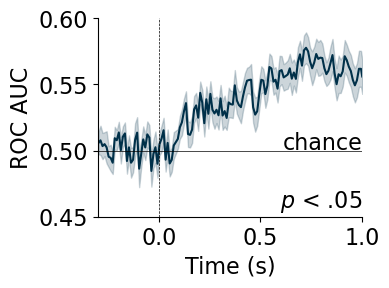

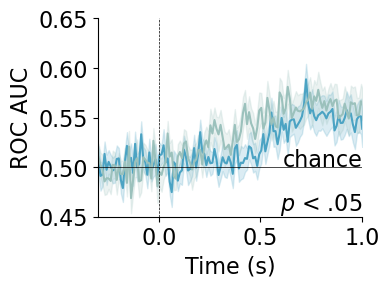

In [13]:
## Contrast: happy vs neutral

data_dict_hn = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["happy", "neutral"],
    vc_list=["mono", "stereo", ""],
    scoring="roc_auc_ovr",
)

if "" in data_dict_hn:
    data_dict_hn["all"] = data_dict_hn.pop("")

if "all" in data_dict_hn:
    fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
    prep_and_plot_from_data(data_dict_hn, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

    fig.savefig(
        Path(paths.FIGURES, "decod_happy-vs-neutral_all.pdf"),
        transparent=True,  # bbox_inches="tight"
    )


fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_hn,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(Path(paths.FIGURES, "decod_happy-vs-neutral_mono-vs-stereo.pdf"), transparent=True, bbox_inches="tight")

### 4. Contrast: Surprised vs Neutral

Found 2 significant clusters for viewing condition 'all'.
Significant cluster: 104.000 - 134.000
Significant cluster: 154.000 - 1000.000
Found 3 significant clusters for viewing condition 'stereo'.
Significant cluster: 164.000 - 214.000
Significant cluster: 374.000 - 434.000
Significant cluster: 534.000 - 1000.000
Found 3 significant clusters for viewing condition 'mono'.
Significant cluster: 274.000 - 314.000
Significant cluster: 334.000 - 484.000
Significant cluster: 524.000 - 1000.000


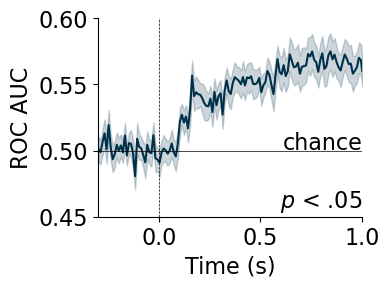

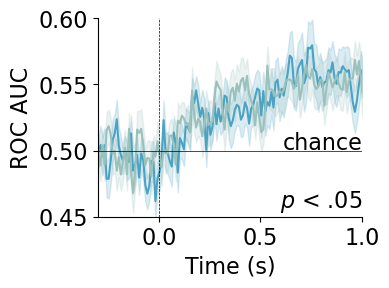

In [14]:
## Contrast: sursprised-neutral

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["surprised", "neutral"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_surpr-vs-neutral_all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_supr-vs-neutral_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

## Stats per time window

In [15]:


timings = TIMINGS()
erp_windows = timings.ERP_WINDOWS


In [16]:

df_plt_mc = pd.DataFrame()

for vc in ["all", "mono", "stereo"]:

    print("\n\n========================================================"
           f"\n========================================================\nViewing condition: {vc}"
            "\n========================================================\n")

    tmp_data = data_dict_allemos[vc]["scores"]
    times = data_dict_allemos[vc]["times"]

    df_tmp = pd.DataFrame()

    for tw in erp_windows:
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(times >= tmin,
                              times <= tmax)
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp[tw] = tmp_data_tw

    df_aov_tmp = pd.melt(df_tmp, var_name="time_win", value_name="score", ignore_index=False).reset_index(names="sub_id")
    print(AnovaRM(df_aov_tmp,
                depvar = "score",
                subject = "sub_id",
                within = ["time_win"]).fit())


    time_wins = list(erp_windows.keys())
    pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                                for j in range(len(time_wins)) if i < j]

    posthoc_results = {}
    for tw1, tw2 in pairwise_comps:
        t_stat, p_val = ttest_rel(df_aov_tmp.query("time_win == @tw1")["score"],
                                df_aov_tmp.query("time_win == @tw2")["score"])
        posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

    p_vals = [p for _, p in posthoc_results.values()]
    _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
    for i, key in enumerate(posthoc_results):
        print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


    df_plt = (df_aov_tmp
            .assign(time_win = pd.Categorical(df_aov_tmp["time_win"], categories=time_wins, ordered=True))
            .sort_values(by=["time_win"])
            .reset_index(drop=True)
    )
    df_plt["viewcond"] = vc

    df_plt_mc = pd.concat([df_plt_mc, df_plt]) if df_plt_mc.size else df_plt





Viewing condition: all

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 22.0116 3.0000 96.0000 0.0000

P1 vs N170: t = -6.27, p = 0.000
P1 vs EPN: t = -6.78, p = 0.000
P1 vs LPC: t = -7.02, p = 0.000
N170 vs EPN: t = -0.15, p = 1.000
N170 vs LPC: t = -1.09, p = 1.000
EPN vs LPC: t = -1.08, p = 1.000


Viewing condition: mono

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 12.6178 3.0000 96.0000 0.0000

P1 vs N170: t = -4.60, p = 0.000
P1 vs EPN: t = -5.41, p = 0.000
P1 vs LPC: t = -4.07, p = 0.002
N170 vs EPN: t = -1.38, p = 1.000
N170 vs LPC: t = -0.10, p = 1.000
EPN vs LPC: t = 1.20, p = 1.000


Viewing condition: stereo

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win  9.0371 3.0000 96.0000 0.0000

P1 vs N170: t = -4.75, p = 0.000
P1 vs EPN: t = -4.09, p = 0.002
P1 vs LPC: t = -3.98, p = 0.002
N170 v

P1 decod performance is lower than the other windows (for all viewing conditions). There is no sigificant difference betweeen the other three windows

In [17]:
print(AnovaRM(df_plt_mc.query("viewcond != 'all'"),
                depvar = "score",
                subject = "sub_id",
                within = ["time_win", "viewcond"]).fit())

                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
time_win          17.8221 3.0000 96.0000 0.0000
viewcond           1.5536 1.0000 32.0000 0.2216
time_win:viewcond  1.0036 3.0000 96.0000 0.3947



In [18]:
aov1 = AnovaRM(df_plt_mc.query("viewcond != 'all'"),
              depvar = "score",
              subject = "sub_id",
              within = ["time_win", "viewcond"]).fit()

aov2 = AnovaRM(df_plt_mc.query("viewcond != 'all'"),
                depvar = "score",
                subject = "sub_id",
                within = ["time_win"],
                aggregate_func="mean").fit()

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/statsmodels/stats/anova.py:512: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.data = (self.data


In [ ]:
from scipy.stats.distributions import chi2
def likelihood_ratio(ll0, ll1):
    return -2 * (ll0-ll1)

def lrtest(fitted_model0,
           fitted_model1) -> (float, float):
    
    L0, L1 = fitted_model0.llf, fitted_model1.llf
    df0, df1 = fitted_model0.df_model, fitted_model1.df_model
    
    chi2_stat = likelihood_ratio(L0,L1)
    p = chi2.sf(chi2_stat, df1-df0)

    return (chi2_stat, p)


from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

m1 = smf.ols(formula="score ~ C(time_win) * C(viewcond)",
             data=df_plt_mc.query("viewcond != 'all'")).fit()
m2 = smf.ols(formula="score ~ C(time_win)",
             data=df_plt_mc.query("viewcond != 'all'")).fit()
anovaResults = anova_lm(m2, m1, test="F")
print(anovaResults)

print(lrtest(m2, m1))

print(m1.compare_lr_test(m2))


   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     260.0  0.229804      0.0       NaN       NaN       NaN
1     256.0  0.225372      4.0  0.004432  1.258513  0.286826
(5.140981833918431, 0.2731353500669637)
(5.140981833918431, 0.2731353500669637, 4.0)


No difference between the two viewing conditions- 

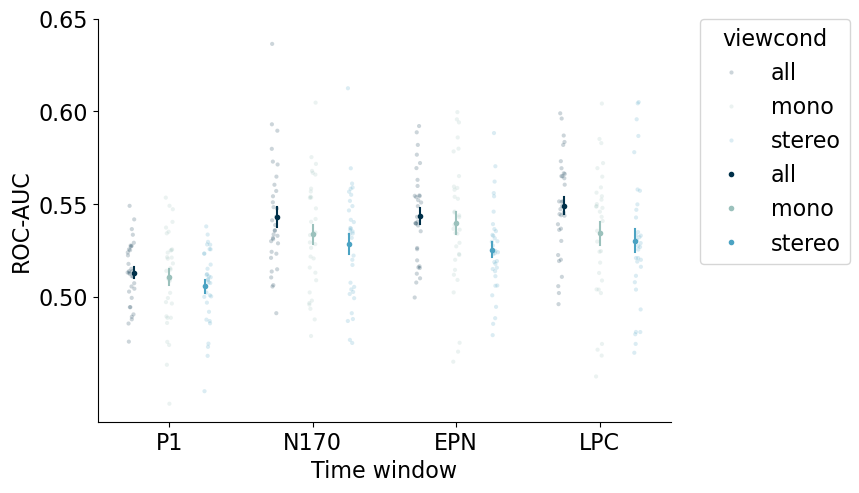

In [18]:


colors = COLORS()


fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

o = sns.stripplot(data=df_plt_mc, x="time_win", y="score", hue="viewcond", dodge=0.01,
                  size=3, jitter=0.075, alpha=0.2, palette = colors.COLDICT, ax=ax)
o = sns.pointplot(
    data=df_plt_mc.reset_index(),
    x="time_win",
    y="score",
    hue="viewcond",
    errorbar="se",
    dodge=0.5,
    palette=colors.COLDICT,
    linestyles='None',
    markers="o",
    markersize=2,
    err_kws={'linewidth': 1.5},
    ax=ax
    )



sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.set_xlabel("Time window")
o.set_ylabel("ROC-AUC")
# set y ticks:
yticks = np.arange(0.5, 0.7, 0.05)
_ = o.set_yticks(yticks)

fig.savefig(
    Path(paths.FIGURES, "decod_time-windows_all-vs-mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [19]:
# Now for all binary contrasts:
df_all = pd.DataFrame()

binary_contrasts = [("angry", "neutral"),
                    ("angry", "happy"),
                    ("angry", "surprised"),
                    ("happy", "neutral"),
                    ("happy", "surprised"),
                    ("surprised", "neutral")]

for c in binary_contrasts:
    data_dict_na = load_decod_res_per_viewcond(
        sub_list_str=sub_list_str,
        conditions=list(c),
        vc_list=[""],
        scoring="roc_auc_ovr",
    )
    if "" in data_dict_na:
        data_dict_na["all"] = data_dict_na.pop("")

    for tw in erp_windows:
        df_tmp = pd.DataFrame()
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(data_dict_na["all"]["times"] >= tmin,
                              data_dict_na["all"]["times"] <= tmax)
        tmp_data = data_dict_na["all"]["scores"]
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp["score"] = tmp_data_tw
        df_tmp["time_win"] = tw
        df_tmp["contrast"] = "_vs_".join(c)
        df_tmp["sub_id"] = sub_list_str
        df_all = pd.concat([df_all, df_tmp]) if df_all.size else df_tmp

print(AnovaRM(df_all,
            depvar = "score",
            subject = "sub_id",
            within = ["time_win", "contrast"]).fit())

                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
time_win          21.1332  3.0000  96.0000 0.0000
contrast           9.4310  5.0000 160.0000 0.0000
time_win:contrast  9.0234 15.0000 480.0000 0.0000



### Post-hoc test: main effect `time-window`

In [25]:
df_posthoc_tw = (df_all
                    .groupby(["time_win", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


time_wins = list(erp_windows.keys())
pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                            for j in range(len(time_wins)) if i < j]

posthoc_results = {}
for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_tw.query("time_win == @tw1")["score"],
                            df_posthoc_tw.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


P1 vs N170: t = -5.93, p = 0.000
P1 vs EPN: t = -6.42, p = 0.000
P1 vs LPC: t = -6.84, p = 0.000
N170 vs EPN: t = -0.15, p = 1.000
N170 vs LPC: t = -0.89, p = 1.000
EPN vs LPC: t = -0.84, p = 1.000


### Post-hoc test: main effect `contrast`

In [26]:
df_posthoc_c = (df_all
                    .groupby(["contrast", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                  for i in range(len(binary_contrasts_str))
                  for j in range(len(binary_contrasts_str)) if i < j]

posthoc_results = {}
for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_c.query("contrast == @c1")["score"],
                            df_posthoc_c.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


angry_vs_neutral vs angry_vs_happy: t = 1.89, p = 1.000
angry_vs_neutral vs angry_vs_surprised: t = 4.99, p = 0.000
angry_vs_neutral vs happy_vs_neutral: t = 5.04, p = 0.000
angry_vs_neutral vs happy_vs_surprised: t = 2.83, p = 0.119
angry_vs_neutral vs surprised_vs_neutral: t = 4.61, p = 0.001
angry_vs_happy vs angry_vs_surprised: t = 3.44, p = 0.025
angry_vs_happy vs happy_vs_neutral: t = 3.38, p = 0.029
angry_vs_happy vs happy_vs_surprised: t = 1.69, p = 1.000
angry_vs_happy vs surprised_vs_neutral: t = 2.77, p = 0.140
angry_vs_surprised vs happy_vs_neutral: t = -0.07, p = 1.000
angry_vs_surprised vs happy_vs_surprised: t = -1.90, p = 1.000
angry_vs_surprised vs surprised_vs_neutral: t = -0.86, p = 1.000
happy_vs_neutral vs happy_vs_surprised: t = -2.43, p = 0.316
happy_vs_neutral vs surprised_vs_neutral: t = -1.07, p = 1.000
happy_vs_surprised vs surprised_vs_neutral: t = 1.30, p = 1.000


In [20]:

df_posthoc_chance = pd.DataFrame()

for time_win in time_wins:  # noqa: B007
  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_all
                  .query("time_win == @time_win")
                  .groupby(["sub_id", "contrast"])
                  .agg({"score": "mean", "contrast": "first"})
                  .reset_index(drop=True)
  )

  binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
  pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                    for i in range(len(binary_contrasts_str))
                    for j in range(len(binary_contrasts_str)) if i < j]

  posthoc_results = {}
  for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("contrast == @c1")["score"],
                              df_posthoc.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  print(f"\nTime window: {time_win}")
  for i, key in enumerate(posthoc_results):
    if p_adj[i] < 0.05:
      print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")

  print("\nContrasts vs chance:")
  posthoc_results = {}
  for c in binary_contrasts_str:
    t_stat, p_val = ttest_1samp(df_posthoc.query("contrast == @c")["score"],
                              0.5)
    posthoc_results[c] = (t_stat, p_val)
  
  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  for i, c in enumerate(posthoc_results):
    if p_adj[i] < 0.05:
      print(f"{c} vs chance: t = {posthoc_results[c][0]:.2f}, p = {p_adj[i]:.5f}")
    
    df_ttmp = pd.DataFrame({"contrast": c,
                              "time_win": time_win,
                              "p_val": p_adj[i],
                              "sign": p_adj[i] < 0.05},
                              index=[0])
    df_posthoc_chance = pd.concat([df_posthoc_chance, df_ttmp]) if df_posthoc_chance.size else df_ttmp


Time window: P1

Contrasts vs chance:
happy_vs_surprised vs chance: t = 4.81, p = 0.00083

Time window: N170
angry_vs_neutral vs angry_vs_surprised: t = 6.92, p = 0.000
angry_vs_neutral vs happy_vs_neutral: t = 7.04, p = 0.000
angry_vs_neutral vs happy_vs_surprised: t = 5.32, p = 0.000
angry_vs_neutral vs surprised_vs_neutral: t = 6.86, p = 0.000
angry_vs_happy vs happy_vs_neutral: t = 3.72, p = 0.046

Contrasts vs chance:
angry_vs_neutral vs chance: t = 9.43, p = 0.00000
angry_vs_happy vs chance: t = 5.87, p = 0.00004
angry_vs_surprised vs chance: t = 4.96, p = 0.00054
happy_vs_neutral vs chance: t = 3.72, p = 0.01842
happy_vs_surprised vs chance: t = 5.18, p = 0.00028
surprised_vs_neutral vs chance: t = 4.40, p = 0.00269

Time window: EPN

Contrasts vs chance:
angry_vs_neutral vs chance: t = 7.14, p = 0.00000
angry_vs_happy vs chance: t = 7.33, p = 0.00000
angry_vs_surprised vs chance: t = 5.29, p = 0.00020
happy_vs_neutral vs chance: t = 3.97, p = 0.00911
happy_vs_surprised vs chan

### Post-hoc test: 2. per contrast

In [21]:
for c in binary_contrasts:  # noqa: B007
  c = "_vs_".join(c)
  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_all
                  .query("contrast == @c")
                  .groupby(["sub_id", "time_win"])
                  .agg({"score": "mean", "time_win": "first"})
                  .reset_index(drop=True)
  )

  pairwise_comps = [(time_wins[i], time_wins[j])
                    for i in range(len(time_wins))
                    for j in range(len(time_wins)) if i < j]

  posthoc_results = {}
  for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("time_win == @tw1")["score"],
                              df_posthoc.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()]
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")

  print(f"\nContrast: {c}")
  for i, key in enumerate(posthoc_results):
    if p_adj[i] < 0.05:
      print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


Contrast: angry_vs_neutral
P1 vs N170: t = -9.78, p = 0.000
P1 vs EPN: t = -5.70, p = 0.000
P1 vs LPC: t = -7.20, p = 0.000
N170 vs EPN: t = 3.47, p = 0.009

Contrast: angry_vs_happy
P1 vs N170: t = -5.57, p = 0.000
P1 vs EPN: t = -5.76, p = 0.000
P1 vs LPC: t = -6.74, p = 0.000

Contrast: angry_vs_surprised

Contrast: happy_vs_neutral
P1 vs LPC: t = -3.58, p = 0.007

Contrast: happy_vs_surprised

Contrast: surprised_vs_neutral
P1 vs LPC: t = -4.50, p = 0.001


(0.4, 0.75)

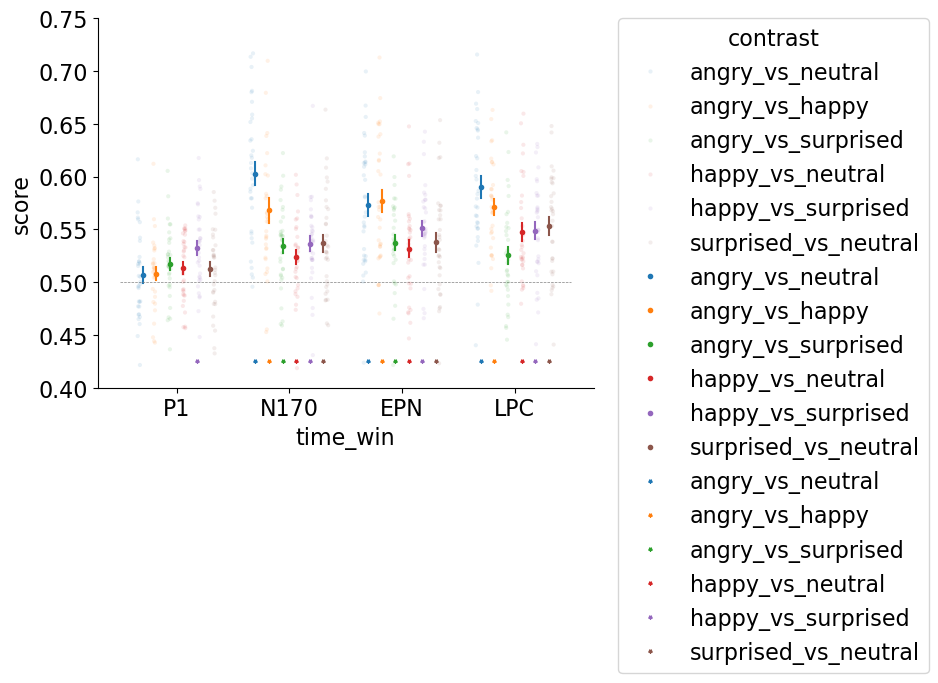

In [187]:
colors = COLORS()


o = sns.stripplot(data=df_all, x="time_win", y="score", hue="contrast", dodge=True,
                  size=3, jitter=0.075,
                  alpha=0.1)
o = sns.pointplot(
    data=df_all.reset_index(),
    x="time_win",
    y="score",
    hue="contrast",
    errorbar="se",
    dodge=0.6,
    #palette=colors.COLDICT,
    linestyles='None',
    markers="o",
    markersize=2,
    err_kws={'linewidth': 1.5},
    )

df_posthoc_chance["y"] = df_posthoc_chance.apply(lambda x: 0.425 if x["sign"] else -0.4, axis=1)

o = sns.pointplot(data=df_posthoc_chance, x="time_win", y="y",
                  hue="contrast", dodge=0.6, markers="*", markersize=2, linestyles="None")

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.hlines(0.5, -0.5, 3.5, linestyles="dashed", linewidth=0.5, color="grey")
o.set_ylim(0.4, 0.75)

## Decoding the viewing condition
Now we see whether we can decode (across all emotions) whether we can decode in which `viewing condition` a trial was shown.

Found 4 significant clusters for viewing condition 'viewcond'.
Significant cluster: 114.000 - 714.000
Significant cluster: 784.000 - 824.000
Significant cluster: 854.000 - 904.000
Significant cluster: 974.000 - 1000.000


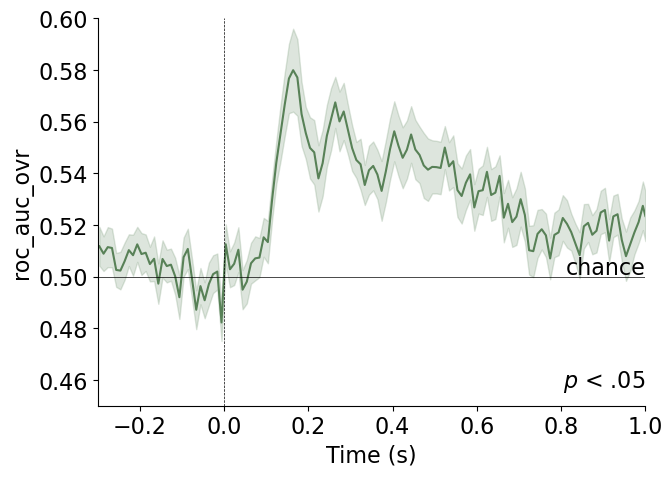

In [4]:
data_dict_vc = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["mono", "stereo"],
    vc_list=[""],
    scoring="roc_auc_ovr",
)
data_dict_vc["viewcond"] = data_dict_vc.pop("")

fig, ax = plt.subplots(1, figsize=(18.8 * cm, 13.3 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_vc,
    subsets=["viewcond"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
    scoring="roc_auc_ovr",
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

fig.savefig(
    Path(paths.FIGURES, "decod_mono-vs-stereo_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [22]:
# Overall:
print("All:")
_ = get_max_decod_score_and_time(data_dict_vc["viewcond"])
# Mono:

All:
Peak mean: M = 0.65, SD = 0.07, 95% CI [0.62, 0.67]
Peak time: M = 184.00, SD = 204.17), 95% CI [114.34, 253.66]


## (Implicit) Decoding Identity

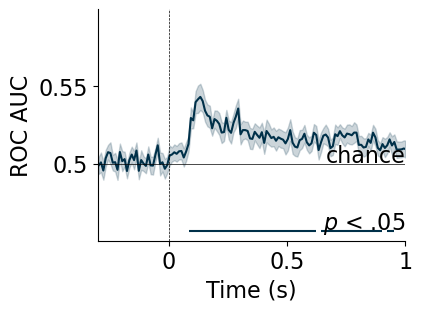

In [13]:
data_dict_id = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["id1", "id2", "id3"],
    vc_list=[""],  # , "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_id["all"] = data_dict_id.pop("")

fig, ax = plt.subplots(1, figsize=(9.3 * cm, 7 * cm))
prep_and_plot_from_data(data_dict_id, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

# set xticks to only 0, 0.5 and 1
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0.5, 0.55])
ax.set_yticklabels([0.5, 0.55])

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_identity_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

# fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
# prep_and_plot_from_data(
#     data_dict=data_dict_id,
#     subsets=["stereo", "mono"],
#     ax=ax,
#     chancelvl=0.333,
#     ylims=(0.3, 0.4),
# )

# Plot patterns

In [49]:
sub_patterns, pat_times = load_patterns(
    sub_list_str,
    contrast_str="surprised_vs_neutral",  # "mono_vs_stereo",  #'surprised_vs_neutral_vs_angry_vs_happy',  #   #
    viewcond="",  # "stereo",  # "mono", # ,
    scoring="roc_auc_ovr",
    reg="",
    labels_shuffled=False,
)

sub_patterns = sub_patterns[:, :, :]
sub_patterns_norm = np.zeros_like(sub_patterns)
# normalize them by L2 norm to allow for unbiased averages:
for sub in range(sub_patterns.shape[0]):
    for time in range(sub_patterns.shape[-1]):
        sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(sub_patterns[sub, :, time])
sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
sub_patterns_avg_norm = np.stack(
    [sub_patterns_avg[:, ii] / l2norm(sub_patterns_avg[:, ii]) for ii in range(sub_patterns_avg.shape[-1])],
    axis=-1,
)

# Build new pseudo Evoke obj:
dummy_epos_info = get_info()
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
info = mne.create_info(ch_names=dummy_epos_info.ch_names, sfreq=(1 / np.median(np.diff(pat_times))), ch_types="eeg")
info.set_montage(easycap_montage)
sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, info, tmin=pat_times[0])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


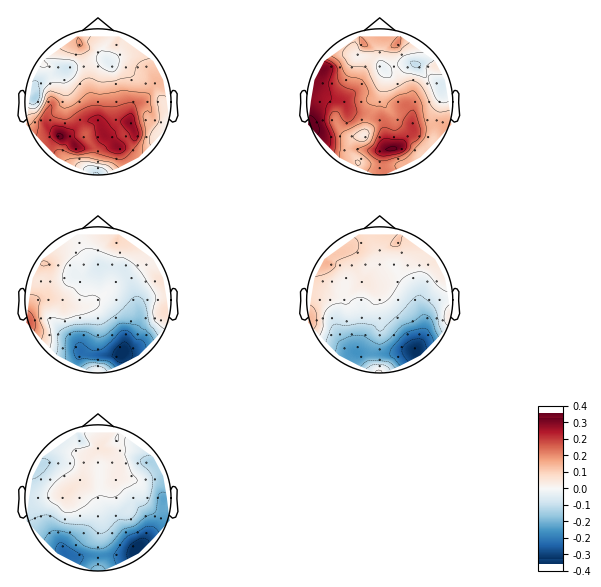

In [19]:
save_fig = True

times_plot = [0.0, 0.1, 0.13, 0.16, 0.2, 0.4, 0.6]

fig, ax = plt.subplots(3, 3, figsize=(16.6 * cm, 15 * cm), gridspec_kw={"width_ratios": [10, 10, 1]})

aaxx = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0]]

for tt, axi in zip(times_plot, aaxx, strict=False):
    # axii = fig.add_subplot(axi)
    t_plot = [tt]
    plt_load = sub_patterns_evo.plot_topomap(
        times=t_plot,
        scalings=1,
        units="",
        #  title="",  # f"{ecc_cond} -- Decod. Target: {config.labels['Load']}",
        cmap="RdBu_r",
        # vmin = -0.3,
        # vmax=0.3,
        contours=10,
        ch_type="eeg",
        extrapolate="local",
        axes=[ax[axi[0], axi[1]], ax[2, 2]],
        show=False,
    )
    ax[axi[0], axi[1]].set_title("")
# cb = ax.figure.colorbar(plt_load, ax=ax_cb)
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])
fig.delaxes(ax[2][1])
plt.show()


if save_fig:
    # save it:
    fig.savefig(Path(paths.FIGURES, "topomap_decod_mono_vs_stereo.pdf"), transparent=True, bbox_inches="tight")

## Source reconstruction

In [50]:
def get_stc(sub_id, contrast):
    """Load the Source timecourses from disk."""
    paths = PATHS()
    fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, contrast, "roc_auc_ovr", "patterns", "src_timecourses", f"{sub_id}")
    stc = mne.read_source_estimate(fpath)
    return stc


def prep_mean_stc(stcs):
    stc_avg = np.array([st.data for st in stcs])

    # normalize per participant and time step by L2 norm to allow for unbiased averages:
    stc_avg_norm = np.zeros_like(stc_avg)
    for sub in range(stc_avg.shape[0]):
        stc_avg_norm[sub, :, :] = stc_avg[sub, :, :] / sum(stc_avg[sub, :, :])
        # for time in range(stc_avg.shape[-1]):
        #    stc_avg_norm[sub, :, time] = stc_avg[sub, :, time] / sum(stc_avg[sub, :, time])

    # avg across participants
    stc_mean_data = np.mean(stc_avg_norm, axis=0)
    stc_mean = stcs[0].copy()  # use as template to get the metadata
    stc_mean.data = stc_mean_data
    stc_mean.subject = "fsaverage"
    return stc_mean


def plot_stc(stc, time=0.2):
    fs_dir = fetch_fsaverage(verbose=False)
    subjects_dir = Path(fs_dir).parent
    kwargs = dict(
        initial_time=time,
        hemi="rh",
        subjects_dir=subjects_dir,
        size=(600, 600),  # clim={'lims':(50, 75, 95), 'kind': 'percent'},  # (0, 10, 20)},
        colormap="hot",
        # transparent=False,
        background="white",
        smoothing_steps=7,
        backend="matplotlib",
        views="par",
        clim={"kind": "percent", "lims": (95, 97.5, 99.9)},
    )
    stc.plot(**kwargs)

Using control points [0.0001819  0.00019472 0.00024581]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


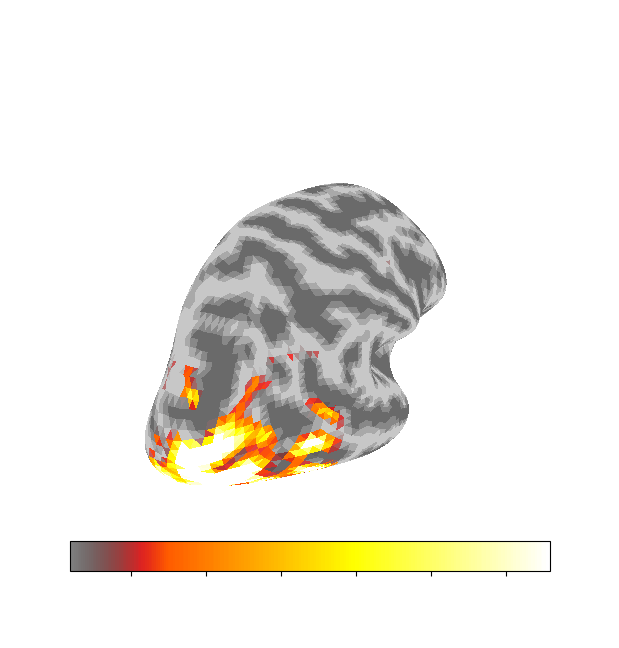

Using control points [0.0001797  0.00019271 0.00024013]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


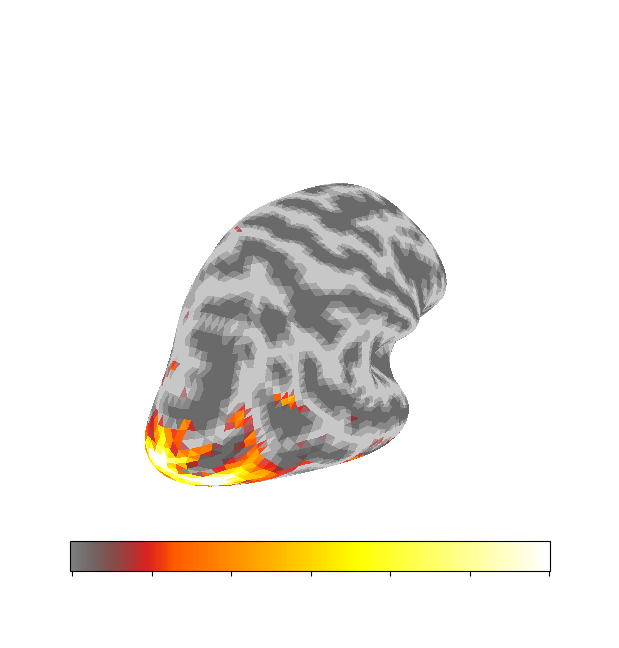

Using control points [0.00017946 0.00019331 0.0002475 ]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


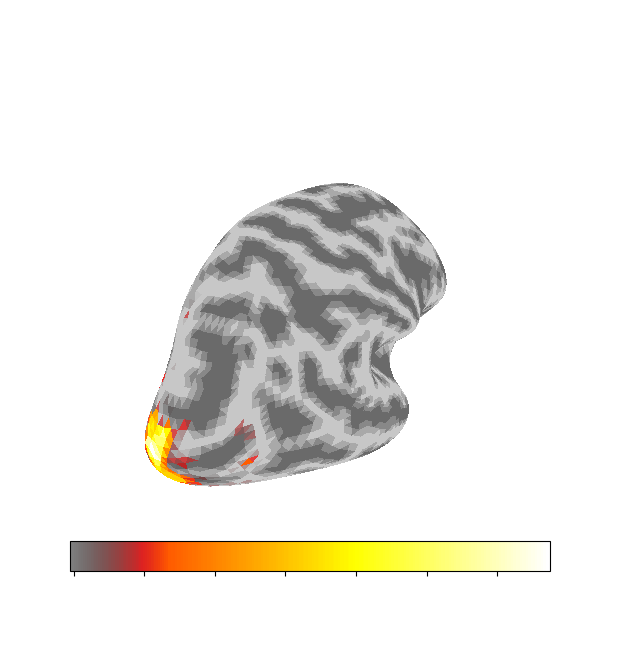

Using control points [0.00017943 0.00019221 0.00023983]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


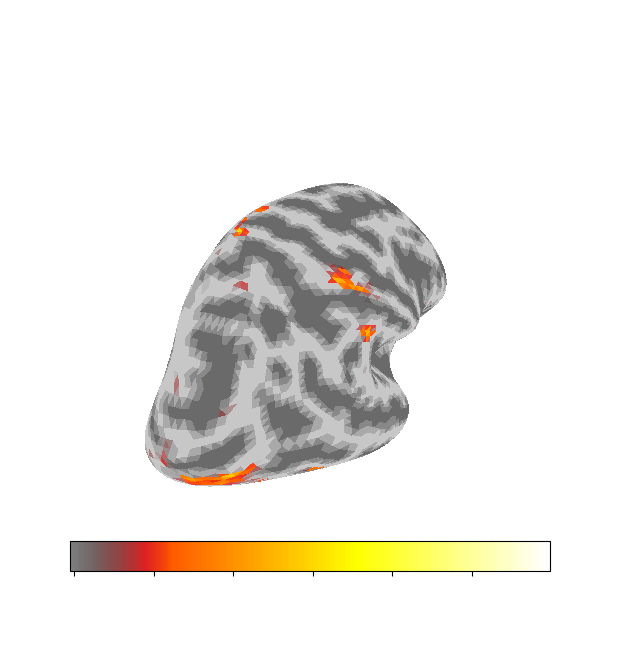

In [51]:
stcs = dict()
contrasts = ["mono_vs_stereo", "angry_vs_neutral", "angry_vs_happy", "happy_vs_neutral"]
for c in contrasts:
    stcs[c] = []
    for sub_id in sub_list_str:
        stc = get_stc(sub_id, c)
        stcs[c].append(stc)
        
for c in contrasts:
    stc_m = prep_mean_stc(stcs[c])
    plot_stc(stc_m, 0.170)

Using control points [0.00019328 0.00020808 0.00032999]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


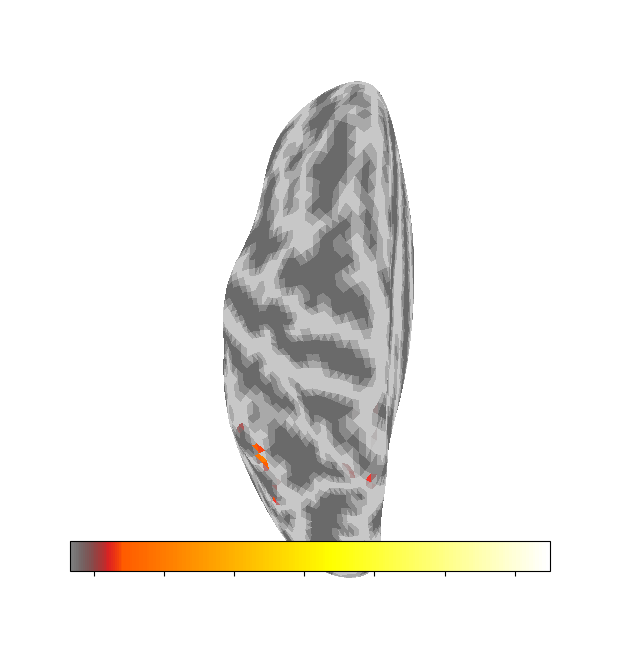

Using control points [0.00018613 0.00019472 0.00025805]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


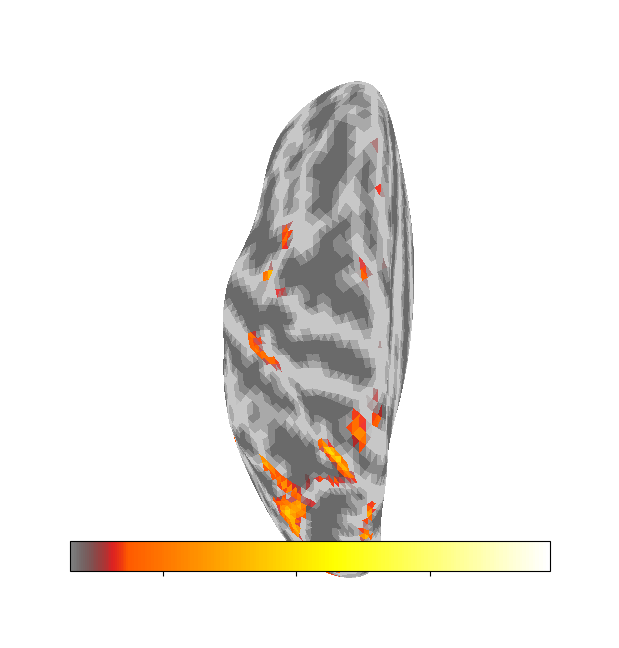

Using control points [0.00018946 0.00020153 0.00030175]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


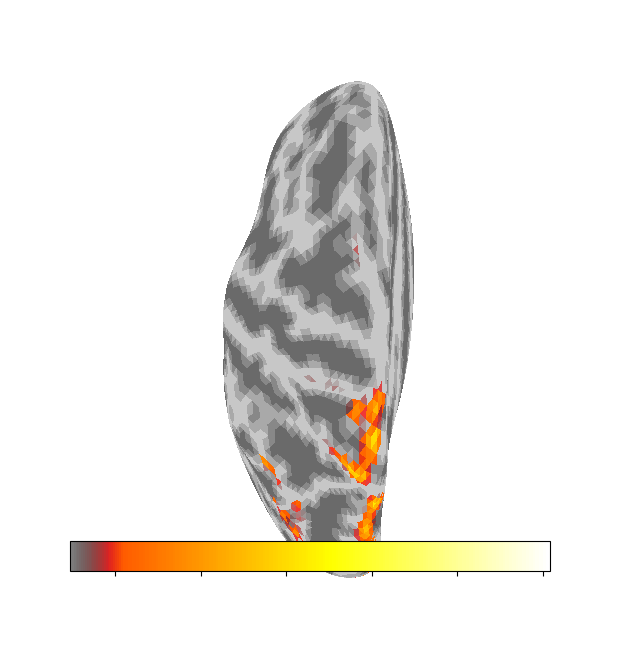

In [74]:
stc_m = prep_mean_stc(stcs["neutral_vs_happy_vs_angry_vs_surprised"])
plot_stc(stc_m, 0.8)
stc_m = prep_mean_stc(stcs["mono_vs_stereo"])
plot_stc(stc_m, 0.8)
stc_m = prep_mean_stc(stcs["id1_vs_id2_vs_id3"])
plot_stc(stc_m, 0.8)